# On Analyzing Real World Time Series for Forecasting: Generated Stationary Data
- NOTES: [real_world_investigations-base.ipynb](https://github.com/Brinkley97/applied_time_series_and_machine_learning/blob/main/framework_for_time_series_data/real_world_investigations-base.ipynb) by Detravious

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '..'))

from collections import namedtuple
from ts_models import Model, AR, EvaluationMetric
from data_loader import build_any_univariate_time_series
from time_series import TimeSeriesFactory, UnivariateTimeSeries

## Generated Stationary Data Pipeline

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, etc)
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation
6. Split Data
7. Initialize Autoregressive AR(p) Model
8. Predict Forecasts
9. Plot Actual Forecasts vs Predicted Forecasts

### Load Raw Data

In [2]:
file = "../datasets/generated_stationary_time_series.npy"

In [3]:
generated_stationary_ts = build_any_univariate_time_series(file)
generated_stationary_ts

UnivariateTimeSeries(Observations)

- `class`: UnivariateTimeSeries
- `object`: temperatures
- `.method()`: get_as_df() and see more below

In [4]:
gsts_df = generated_stationary_ts.get_as_df()
gsts_df

Observations
Timestamp              
0          0.000000e+00
1          5.877853e-01
2          9.510565e-01
3          9.510565e-01
4          5.877853e-01
...                 ...
95         5.879543e-15
96        -5.877853e-01
97        -9.510565e-01
98        -9.510565e-01
99        -5.877853e-01

[100 rows x 1 columns]

### Plot Raw Data

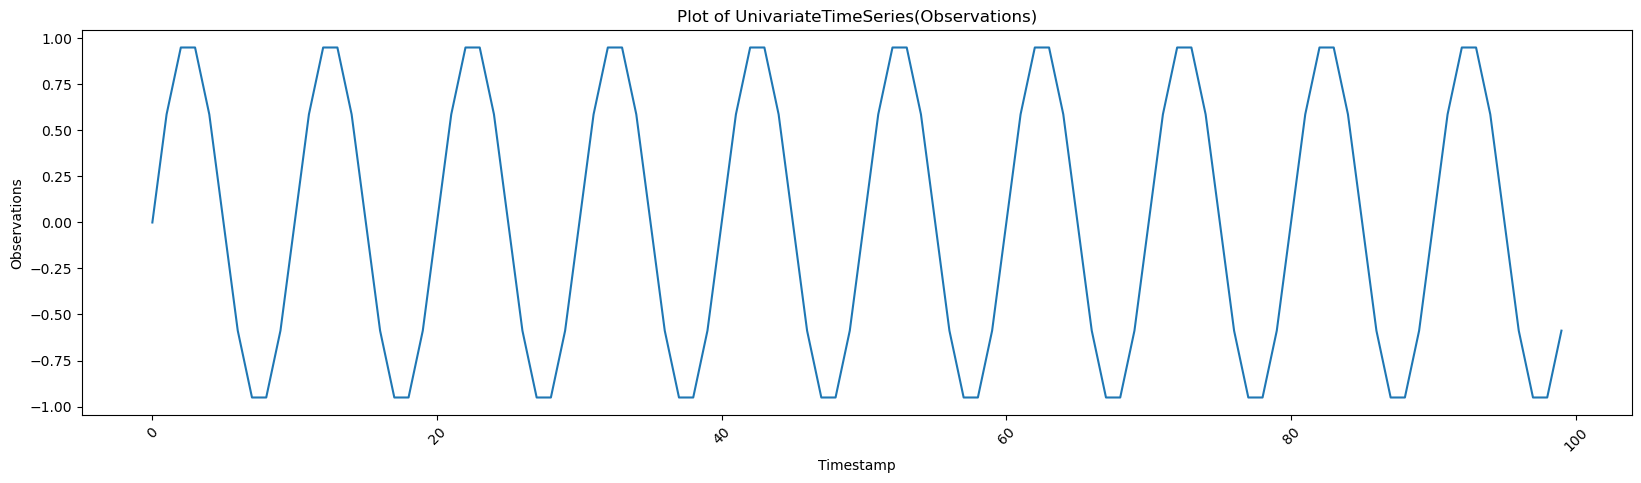

In [5]:
generated_stationary_ts.plot(tick_skip=20)

### Get Descriptive Statistics

In [6]:
generated_stationary_ts.get_statistics()

Observations
count  1.000000e+02
mean  -2.553513e-17
std    7.106691e-01
min   -9.510565e-01
25%   -5.877853e-01
50%   -3.673940e-16
75%    5.877853e-01
max    9.510565e-01

In [7]:
generated_stationary_ts.max_min_range()

{'Max': Observations    0.951057
 dtype: float64,
 'Min': Observations   -0.951057
 dtype: float64,
 'Range': Observations    1.902113
 dtype: float64}

### Check Stationarity of Raw Data

In [8]:
generated_stationary_ts.stationarity_test(gsts_df)

ADF Statistic: -1002118370977237.000000
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


### Plot Autocorrelation and Partial Autocorrelation
- How the relationship between the current observation and it's historical observations correlate at that specific k-th lag.
- In this case, we have a cycle of postive correlation and negative correlation for every 4 observations.
- Look at which points fall outside of blue region.

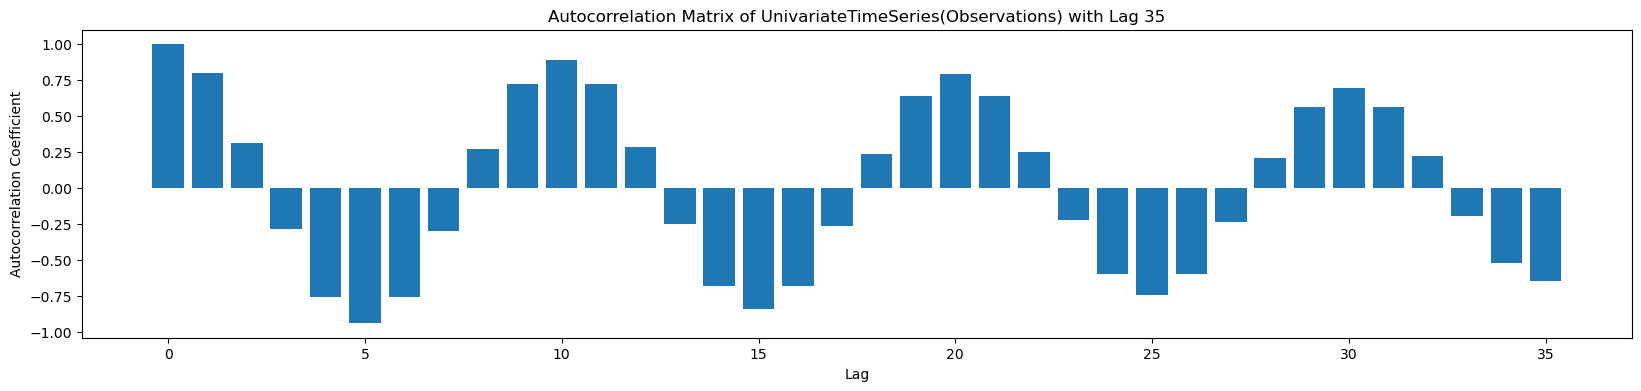

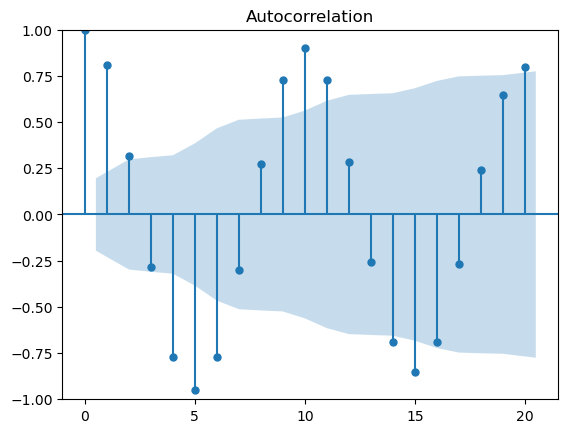

In [9]:
generated_stationary_ts.plot_autocorrelation(35)

- Here, the k-th observations is the 3rd that falls outside of blue region
- Why do this differ from ACor so much?

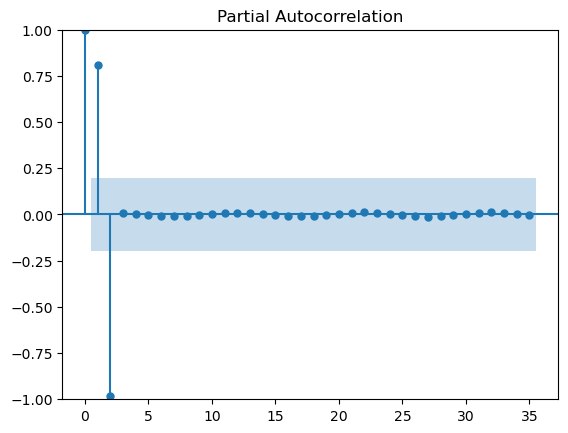

In [10]:
generated_stationary_ts.plot_partial_autocorrelation(35)

### Split Data
- Splitting so we can forecast the last 7 days. Do this type of forecast to see how model is performing. If model performs how we need, then update notebook to forecast the next 7 days.

In [11]:
train, validation, test = generated_stationary_ts.get_train_validation_test_split(0.93, 0.0)

0 93
93 93
93 100


In [12]:
train.get_as_df()

UnivariateTimeSeries(Observations)[0:93]
Timestamp                                          
0                                      0.000000e+00
1                                      5.877853e-01
2                                      9.510565e-01
3                                      9.510565e-01
4                                      5.877853e-01
...                                             ...
88                                    -9.510565e-01
89                                    -5.877853e-01
90                                    -2.204364e-15
91                                     5.877853e-01
92                                     9.510565e-01

[93 rows x 1 columns]

In [13]:
validation.get_as_df()

Empty DataFrame
Columns: [UnivariateTimeSeries(Observations)[93:93]]
Index: []

In [14]:
test.get_as_df()

UnivariateTimeSeries(Observations)[93:100]
Timestamp                                            
93                                       9.510565e-01
94                                       5.877853e-01
95                                       5.879543e-15
96                                      -5.877853e-01
97                                      -9.510565e-01
98                                      -9.510565e-01
99                                      -5.877853e-01

In [15]:
expected_forecast = test.get_series()
expected_forecast

array([ 9.51056516e-01,  5.87785252e-01,  5.87954260e-15, -5.87785252e-01,
       -9.51056516e-01, -9.51056516e-01, -5.87785252e-01])

### Initialize Autoregressive AR(p) Model
- How to determine the proper lag value? Look at the Partial ACor plot. Being that we're out of the blue area at lag 3, we'll set our lag to be 3. 
    - Why Partial ACor plot and not ACor plot?
    - What if we take lags from ACor plot anyway? Say lags 5, 10, and 15 because they all have the most correlation (postive and negative) for their clusters, respectfully.
- How to understand the model summary?

In [16]:
lags_to_test = [3, 5, 10, 15]

In [17]:
ar_model_class = AR()

trained_ar_models = ar_model_class.train_ar_model(train.get_series(), lags_to_test)

Model 1 with a lag of 3
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   93
Model:                     AutoReg(3)   Log Likelihood                 236.649
Method:               Conditional MLE   S.D. of innovations              0.017
Date:                Sat, 09 Dec 2023   AIC                           -463.297
Time:                        19:35:25   BIC                           -450.798
Sample:                             3   HQIC                          -458.257
                                   93                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.551e-17      0.002  -3.02e-14      1.000      -0.004       0.004
y.L1           1.0322   7.62e+11   1.35e-12      1.000   -1.49e+12    1.49e+12
y.L2          -0.0215   1.23

In [18]:
len_historical_data, historical_data = train.get_historical_data()
len_historical_data

93

### Predict Forecasts

In [19]:
predictions = ar_model_class.predict(trained_ar_models, len_historical_data, train, test)
predictions

TypeError: predict() takes 4 positional arguments but 5 were given

In [ ]:
mse_gsts = EvaluationMetric.eval_mse(expected_forecast, predictions)
mse_gsts

### Plot Actual Forecasts vs Predicted Forecasts

In [ ]:
EvaluationMetric.plot_forecast(expected_forecast, predictions, lags_to_test)

### Follow-up
- What can we determine from this?
- Which AR(p) lag performs the best?
- Can we do better?